# Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
import warnings; warnings.simplefilter('ignore')

/home/ario/anaconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names, data

(array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
        'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
        'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14'),
 array([['GRB241026A', 'GRB241025C', 'GRB241025B*', ..., 'GRB910424A*',
         'GRB910423A*', 'GRB910421A*'],
        ['None', 'GRB241025650', 'GRB241025546', ..., 'None', 'None',
         'None'],
        ['22:42:31', '15:36:07.391', '13:06:35.580', ..., '19:43:25.064',
         '19:51:15.804', '9:14:03.800'],
        ...,
        ['-999', '4.9920', '37.8890', ..., '3.1360', '208.5760', '5.6960'],
        ['False', 'True', 'True', ..., 'False', 'False', 'False'],
        ['60609.94619213', '60608.65008554', '60608.54624514', ...,
         '48370.82181787', '48369.82726625', '48367.38476620']],
       dtype='<U14'))

In [4]:
T90_s = np.array(data[6], dtype=float)
z_s = np.array(data[11], dtype=float)
fluence_s = np.array(data[9], dtype=float)

Mask the unphisical values!

In [5]:
z_cor = z_s[z_s > 0]
fluence_cor = fluence_s[fluence_s > 0]
T90_cor = T90_s[T90_s > 0]

# 1-D Distributions

Text(0.5, 1.0, '$z$ Distribution')

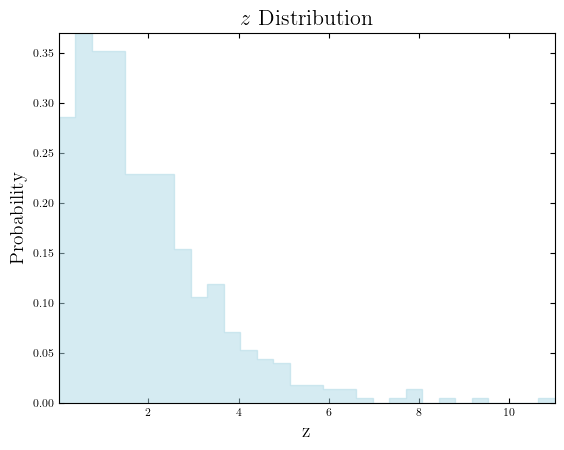

In [6]:
plt.hist(z_cor, bins=30, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue')
plt.xlabel('z', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$z$ Distribution', fontsize=16)

Text(0.5, 1.0, '$T_{90}$ Distribution')

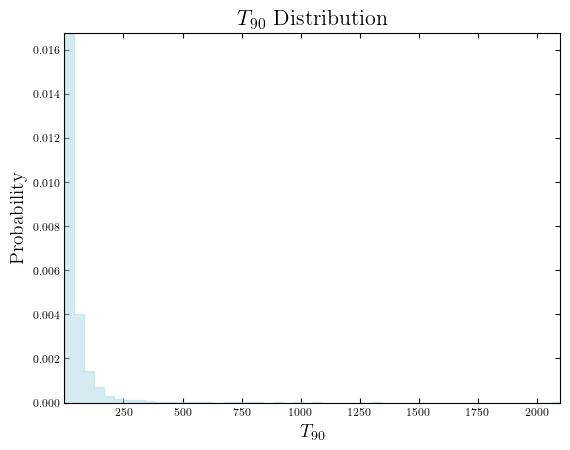

In [7]:
plt.hist(T90_cor, bins=50, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue')
plt.xlabel(fr'$T_{{90}}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$T_{{90}}$ Distribution', fontsize=16)

Text(0.5, 1.0, 'Flux Distribution')

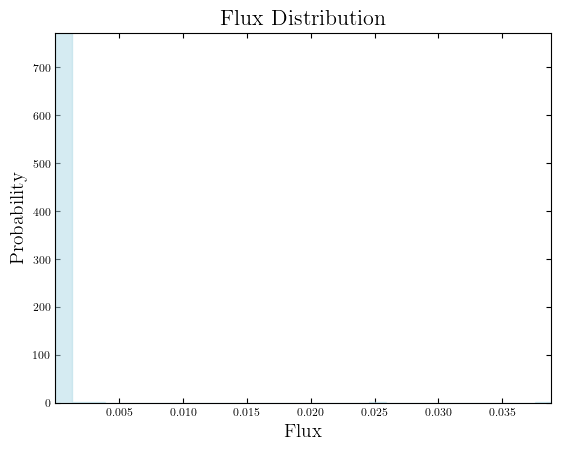

In [8]:
plt.hist(fluence_cor, bins=30, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue')
plt.xlabel(fr'Flux', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'Flux Distribution', fontsize=16)

#### If I look at the plot of the $T_{90}$ and of the flux, it's not easy to extrapolate information from these. So I switch to log scale.

In [9]:
logbins_f   =  np.arange(start=np.log(fluence_cor).min(), stop=np.log(fluence_cor).max(), step=0.2)
logbins_T90 =  np.arange(start=np.log(T90_cor).min(), stop=np.log(T90_cor).max(), step=0.2)

Text(0.5, 1.0, '$\\log_{10} T_{90}$ Distribution')

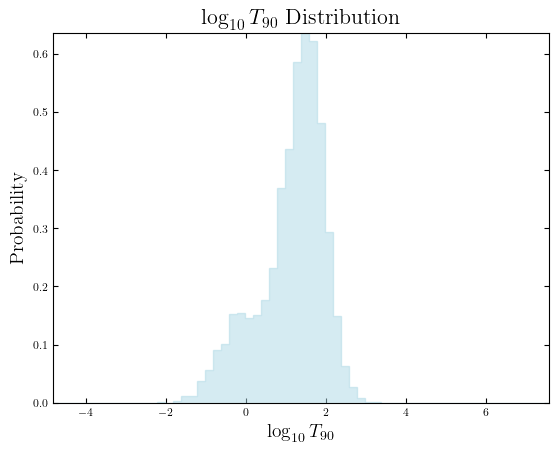

In [10]:
plt.hist(np.log10(T90_cor), bins=logbins_T90, alpha=0.5, histtype='step', fill=True, density=True, color='lightblue')
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)  # Correggi la notazione LaTeX
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$\log_{{10}} T_{{90}}$ Distribution', fontsize=16)

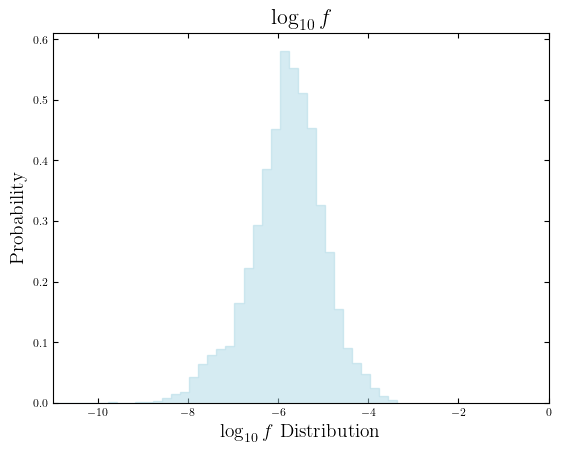

In [11]:
plt.hist(np.log10(fluence_cor), bins=logbins_f,histtype='step', fill=True, density=True, color='lightblue', alpha=0.5)
plt.xlabel(fr'$\log_{{10}} f$ Distribution', fontsize=14)
plt.xlim(-11, 0)
plt.ylim(0,0.61)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$\log_{{10}} f$', fontsize=16);

In [12]:
from sklearn.neighbors import KernelDensity

def kde_sklearn(data, bandwidth):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

## Start by trying to better explore our data using a KDE
### $z$ Distribution

In [13]:
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.01, 1, 40)

K = 5   # 5-Fold CrossValidation

zgrid = z_cor[:, None]
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(zgrid)

opt_bw_z = grid.best_params_['bandwidth']

print('Optimal Bandwidth: ', opt_bw_z)

Optimal Bandwidth:  0.4923076923076923


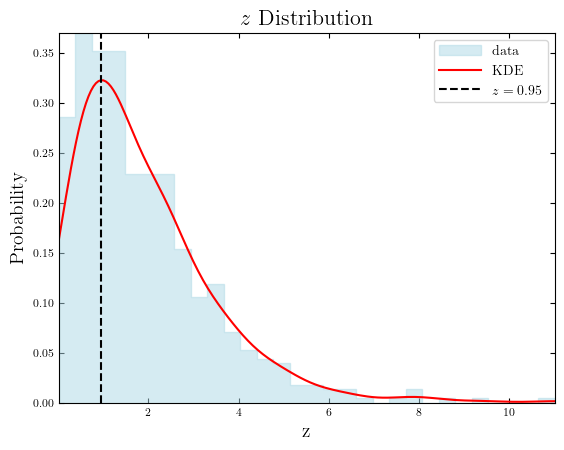

In [14]:
xgrid = np.linspace(np.min(z_cor), np.max(z_cor), 200)
z_cor_pdf = kde_sklearn(z_cor, bandwidth=opt_bw_z)

plt.hist(z_cor, bins=30, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue', label='data')
plt.plot(xgrid, z_cor_pdf, color='red', label='KDE')
plt.axvline(x=xgrid[np.argmax(z_cor_pdf)], color='black', linestyle='--', label=fr'$z={xgrid[np.argmax(z_cor_pdf)]:.2f}$')
plt.xlabel('z', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$z$ Distribution', fontsize=16)
plt.legend(fontsize=10);

We can clearly see that there is no bimodality in this distribution and that there is a peak around $z \sim 1$ (precisely at $z=0.95$).

## $\log_{10} {T_{90}}$ Distribution

In [15]:
T90grid = np.log10(T90_cor[:, None])
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(T90grid)

opt_bw_T90 = grid.best_params_['bandwidth']

print('Optimal Bandwidth: ', opt_bw_T90)

Optimal Bandwidth:  0.11153846153846153


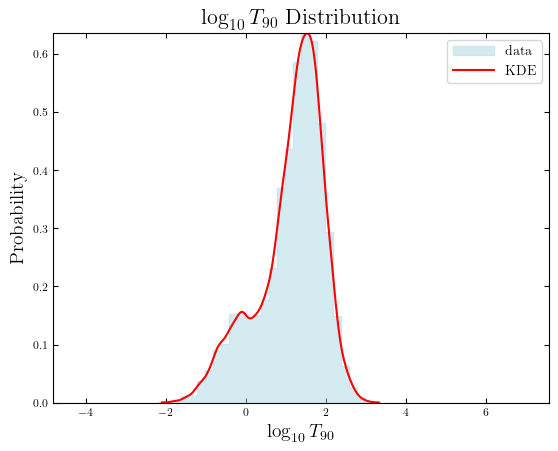

In [16]:
xgrid = np.linspace(np.min(np.log10(T90_cor)), np.max(np.log10(T90_cor)), 200)
T90_cor_pdf = kde_sklearn(np.log10(T90_cor), bandwidth=opt_bw_T90)

plt.hist(np.log10(T90_cor), bins=logbins_T90, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue', label='data')
plt.plot(xgrid, T90_cor_pdf, color='red', label='KDE')
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$\log_{{10}} T_{{90}}$ Distribution', fontsize=16)
plt.legend(fontsize=10);

We can see a bimodality in the distribution of the $T_{90}$. We'll go deeper into this in the exercise!

## $\log_{10} f$ Distribution

In [17]:
fgrid = np.log10(fluence_cor[:, None])
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(fgrid)

opt_bw_f = grid.best_params_['bandwidth']

print('Optimal Bandwidth: ', opt_bw_f)

Optimal Bandwidth:  0.28923076923076924


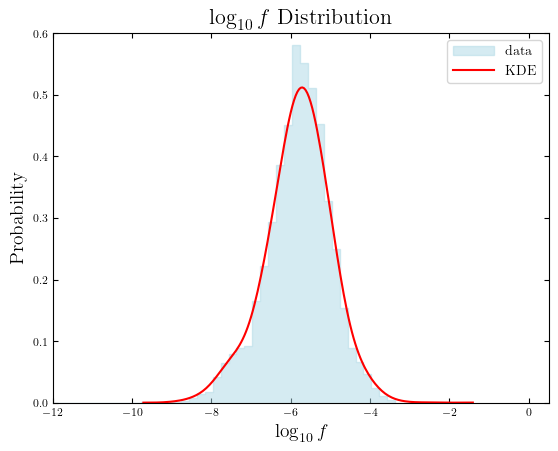

In [18]:
xgrid = np.linspace(np.min(np.log10(fluence_cor)), np.max(np.log10(fluence_cor)), 200)
f_cor_pdf = kde_sklearn(np.log10(fluence_cor), bandwidth=opt_bw_f)

plt.hist(np.log10(fluence_cor), bins=logbins_f, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue', label='data')
plt.plot(xgrid, f_cor_pdf, color='red', label='KDE')
plt.xlabel(fr'$\log_{{10}} f$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$\log_{{10}} f$ Distribution', fontsize=16)
plt.xlim(-12, 0.5)
plt.ylim(0, 0.6)
plt.legend(fontsize=10);

## Clustering: Explore the bimodality in the $\log_{10} T_{90}$ distribution

In [19]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

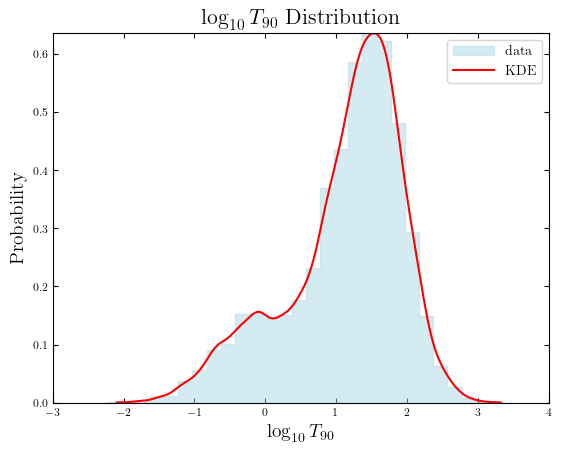

In [20]:
xgrid = np.linspace(np.min(np.log10(T90_cor)), np.max(np.log10(T90_cor)), 200)
T90_cor_pdf = kde_sklearn(np.log10(T90_cor), bandwidth=opt_bw_T90)

plt.hist(np.log10(T90_cor), bins=logbins_T90, alpha=0.5, histtype='step', density=True, fill=True, color='lightblue', label='data')
plt.plot(xgrid, T90_cor_pdf, color='red', label='KDE')
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title(fr'$\log_{{10}} T_{{90}}$ Distribution', fontsize=16)
plt.xlim(-3, 4)
plt.legend(fontsize=10);

We can make the hypothesis about the presence of $n=2$ clusters. Just keep it as an initial point for our investigation.

In [21]:
# Number of clusters definition
n_cluster = 2

# Data Normalization (optional but recomended)
# scaler = preprocessing.StandardScaler()
# T90_scaled = scaler.fit_transform(T90grid)

# KMeans Clustering
k_means = KMeans(n_clusters=n_cluster)
k_means.fit(T90grid)

# Clusters Prediction
Y_T90 = k_means.predict(T90grid)

# Centroids
centroids = k_means.cluster_centers_

In [22]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style('whitegrid')

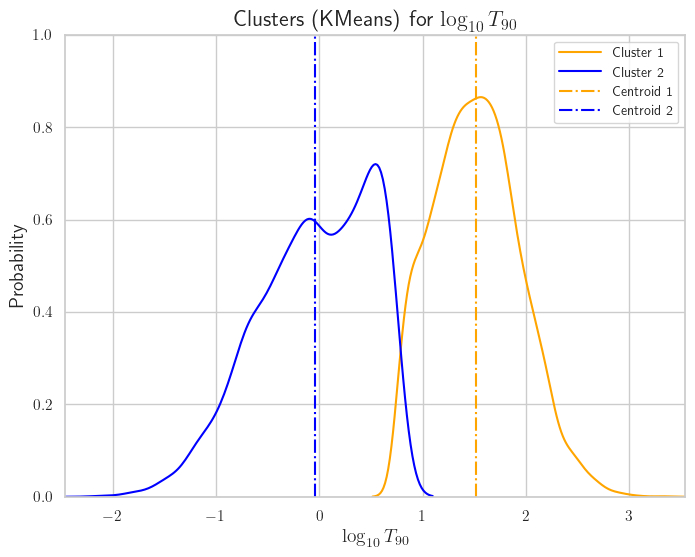

In [23]:
sns.kdeplot(T90grid[Y_T90==0].flatten(), color='orange', label='Cluster 1')
sns.kdeplot(T90grid[Y_T90==1].flatten(), color='blue',  label='Cluster 2')
plt.axvline(x = centroids[0], linestyle='-.', color='orange', label='Centroid 1')
plt.axvline(x = centroids[1], linestyle='-.', color='blue',  label='Centroid 2')
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.ylim(0,1)
plt.title(fr'Clusters (KMeans) for $\log_{{10}} T_{{90}}$', fontsize=16)
plt.legend(fontsize=10);

#### Is my initial choice of 2 clusters correct? 
Try to use the meanshift algorithm!

In [24]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [25]:
bandwidth = estimate_bandwidth(T90grid, quantile=0.2)
print('Optimal bandwidth: ', bandwidth)

Optimal bandwidth:  0.36816828398941737


In [26]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(T90grid)
Y_T90_ms = ms.predict(T90grid)

In [27]:
labels = ms.labels_

In [28]:
# Number of clusters found (ignoring outliers)
n_clusters = len(np.unique(labels[labels != -1]))  # Filters outliers (-1)
print(f"Number of clusters (excluding outliers): {n_clusters}")

Number of clusters (excluding outliers): 2


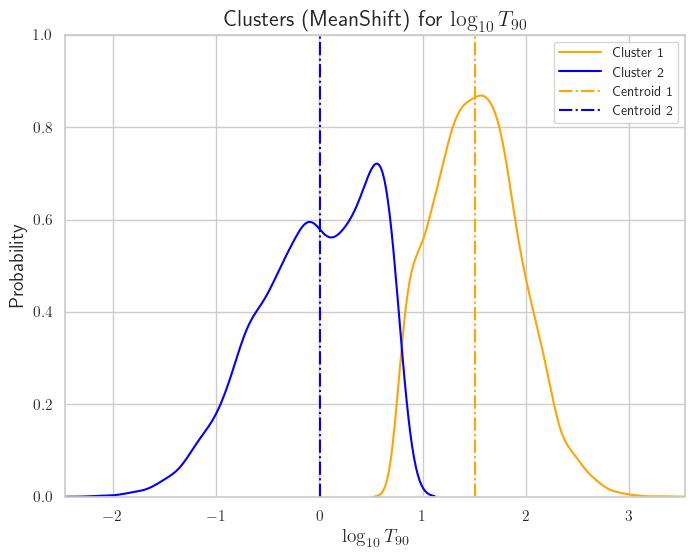

In [29]:
sns.kdeplot(T90grid[Y_T90_ms==0].flatten(), color='orange', label='Cluster 1')
sns.kdeplot(T90grid[Y_T90_ms==1].flatten(), color='blue',  label='Cluster 2')
plt.axvline(x = ms.cluster_centers_[0], linestyle='-.', color='orange', label='Centroid 1')
plt.axvline(x = ms.cluster_centers_[1], linestyle='-.', color='blue',  label='Centroid 2')
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.ylim(0,1)
plt.title(fr'Clusters (MeanShift) for $\log_{{10}} T_{{90}}$', fontsize=16)
plt.legend(fontsize=10);

In [30]:
print('KMeans centres:   ', centroids.flatten())
print('Meanshift centres:', ms.cluster_centers_.flatten())

KMeans centres:    [ 1.52159123 -0.0415076 ]
Meanshift centres: [1.50506383 0.00313961]


The two clustering methods return more or less the same results, so they can be used both indifferently for 1-D distributions!

# 2-D Distributions

In [31]:
sns.set_style('white')

In [32]:
# mask for non physical values
mask = np.logical_and(fluence_s>0, T90_s>0)
flux_corr = fluence_s[mask]
T90_corr  = T90_s[mask]

Text(0.5, 1.0, '$\\log_{10} T_{90}$ VS $\\log_{10} f$')

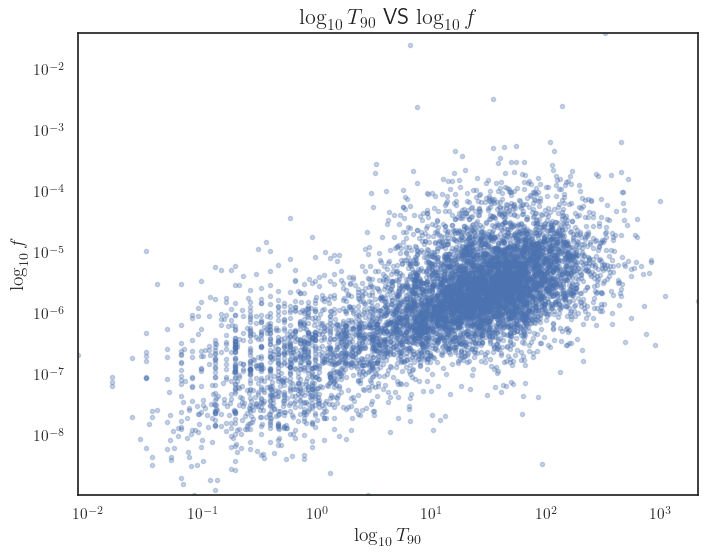

In [33]:
plt.loglog(T90_corr, flux_corr, '.', alpha=0.3)
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)
plt.ylabel(fr'$\log_{{10}} f$', fontsize=14)
plt.title(fr'$\log_{{10}} T_{{90}}$ VS $\log_{{10}} f$', fontsize=16)

In [34]:
matrix   = np.array((np.log10(T90_corr), np.log10(flux_corr)))
f_vs_T90 = matrix.transpose()

## KMeans
### I can see the presence of 2 clusters depending on the value of $T_{90}$

In [35]:
n_clusters = 2 
k_means    = KMeans(n_clusters)

k_means.fit(f_vs_T90)

KMeans(n_clusters=2)

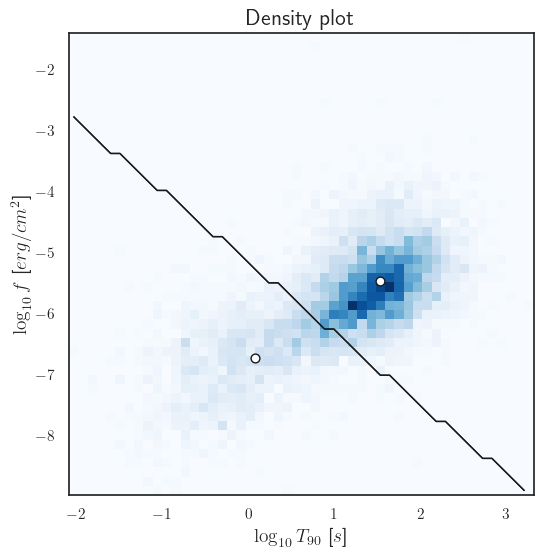

In [36]:
# Make some plots
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_T90[:,0], f_vs_T90[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = k_means.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = k_means.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = k_means.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(fr"$\log_{{10}} T_{{90}}$ [$s$]", fontsize=14)
ax.set_ylabel(fr"$\log_{{10}} f$ [$erg/cm^2$]", fontsize=14)
ax.set_title("Density plot", fontsize=16)

plt.show();

## MeanShift

In [37]:
bandwidth = estimate_bandwidth(f_vs_T90, quantile=0.2)
print('Optimal bandwidth: ', bandwidth)

Optimal bandwidth:  0.7390540735919161


In [38]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit((f_vs_T90))

MeanShift(bandwidth=0.7390540735919161, bin_seeding=True, cluster_all=False)

In [39]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 2
number of estimated singletons : 2
total number of estimated clusters : 4


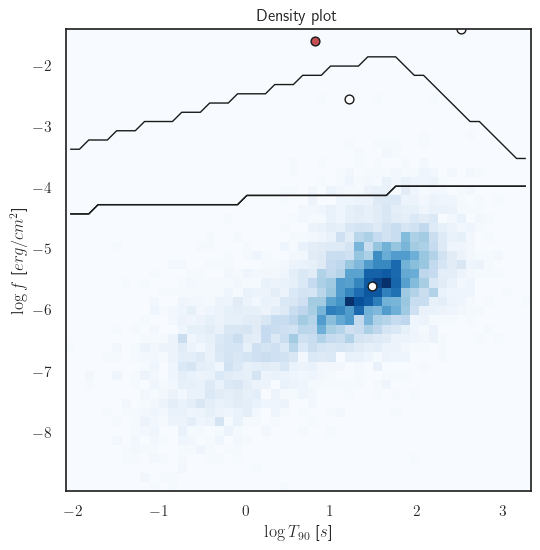

In [40]:
counts_tot = np.array([ms.labels_.tolist().count(u) for u in labels_unique])

# Make some plots
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_T90[:, 0], f_vs_T90[:, 1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = ms.cluster_centers_
for i in range(0, len(ms.cluster_centers_)): 
    
    if counts_tot[i]==1: 

        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='r', edgecolors='k')
    else: 
        
        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$\log{T_{90}}$ [$s$]")
ax.set_ylabel("$\log{f}$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

We can see there is a different behaviour here between the two methods. The MeanShift algorithms finds a centre in the bulge of the distribution. Maybe changing some of the parameters somthing happens!

In [41]:
ms = MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)
ms.fit((f_vs_T90))

MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)

In [42]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 3
number of estimated singletons : 6
total number of estimated clusters : 9


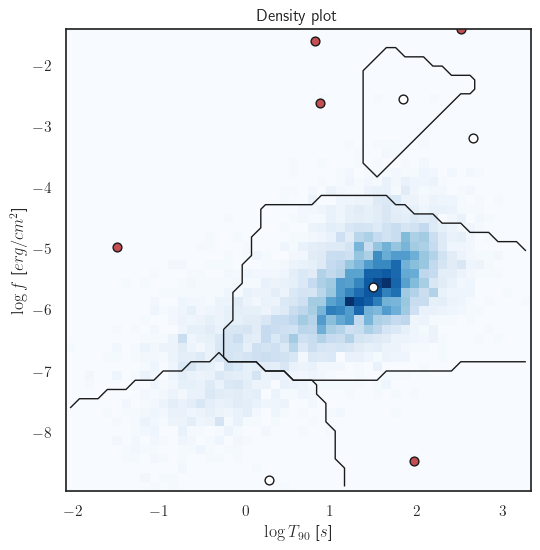

In [43]:
counts_tot = np.array([ms.labels_.tolist().count(u) for u in labels_unique])

# Make some plots
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_T90[:, 0], f_vs_T90[:, 1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = ms.cluster_centers_
for i in range(0, len(ms.cluster_centers_)): 
    
    if counts_tot[i]==1: 

        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='r', edgecolors='k')
    else: 
        
        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$\log{T_{90}}$ [$s$]")
ax.set_ylabel("$\log{f}$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

## Gaussian Mixture

In [44]:
from sklearn import mixture

In [45]:
gaussianmix = mixture.GaussianMixture(n_components=2, random_state=0)
gaussianmix.fit(f_vs_T90)
c = gaussianmix.fit_predict(f_vs_T90)

In [46]:
# Clusters centres
xc1, yc1 = gaussianmix.means_[0]
xc2, yc2 = gaussianmix.means_[1]

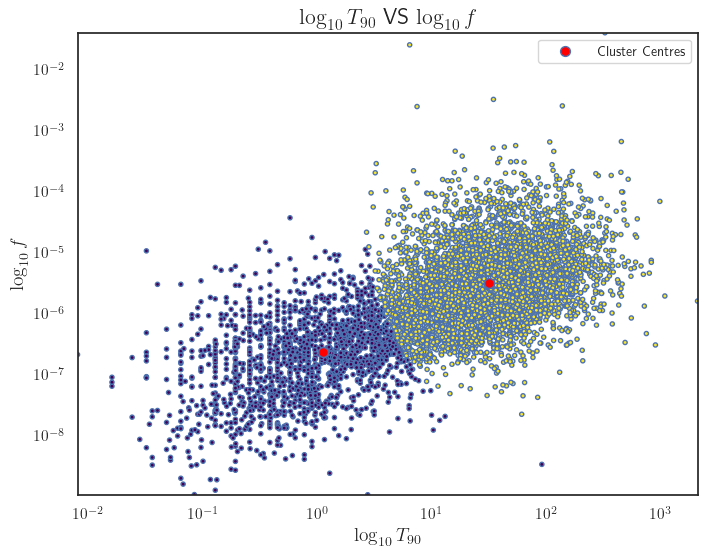

In [47]:
plt.scatter(T90_corr, flux_corr, c=c, cmap='viridis', marker='.')
plt.scatter(10**xc1, 10**yc1, c='red', s=50, label='Cluster Centres')
plt.scatter(10**xc2, 10**yc2, c='red', s=50)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(fr'$\log_{{10}} T_{{90}}$', fontsize=14)
plt.ylabel(fr'$\log_{{10}} f$', fontsize=14)
plt.title(fr'$\log_{{10}} T_{{90}}$ VS $\log_{{10}} f$', fontsize=16)
plt.legend(fontsize=10);

There are two semi-distinct populations of burst, which depend on the duration only. The other two distributions seem to be one-modal.
This can be associated to the fact that there are two types of Gamma Ray Bursts:
-   **Short GRBs**: Last less than 2 seconds and are thought to result from the merger of compact objects like neutron stars or a neutron star with a black hole.
-   **Long GRBs**: Last more than 2 seconds and are associated with the collapse of massive stars (supernovae) in distant galaxies.

**ALGORITHMS**: the `KMeans` method appears to be more solid, while the `MeanShift` algorithm seems to be more sensible to outliers.

## Errors
### In the dataset there are also the errors associated to the data!

In [48]:
T90_s = np.array(data[6],dtype=float)
z_s = np.array(data[11],dtype=float)
fluence_s = np.array(data[9],dtype=float)
T90_s_err = np.array(data[7],dtype=float)
fluence_s_err = np.array(data[10],dtype=float)

In [49]:
mask = np.logical_and(T90_s>0, fluence_s>0)

T90_corr = T90_s[mask]
T90_corr_err = T90_s_err[mask]

fluence_corr = fluence_s[mask]
fluence_corr_err = fluence_s_err[mask]

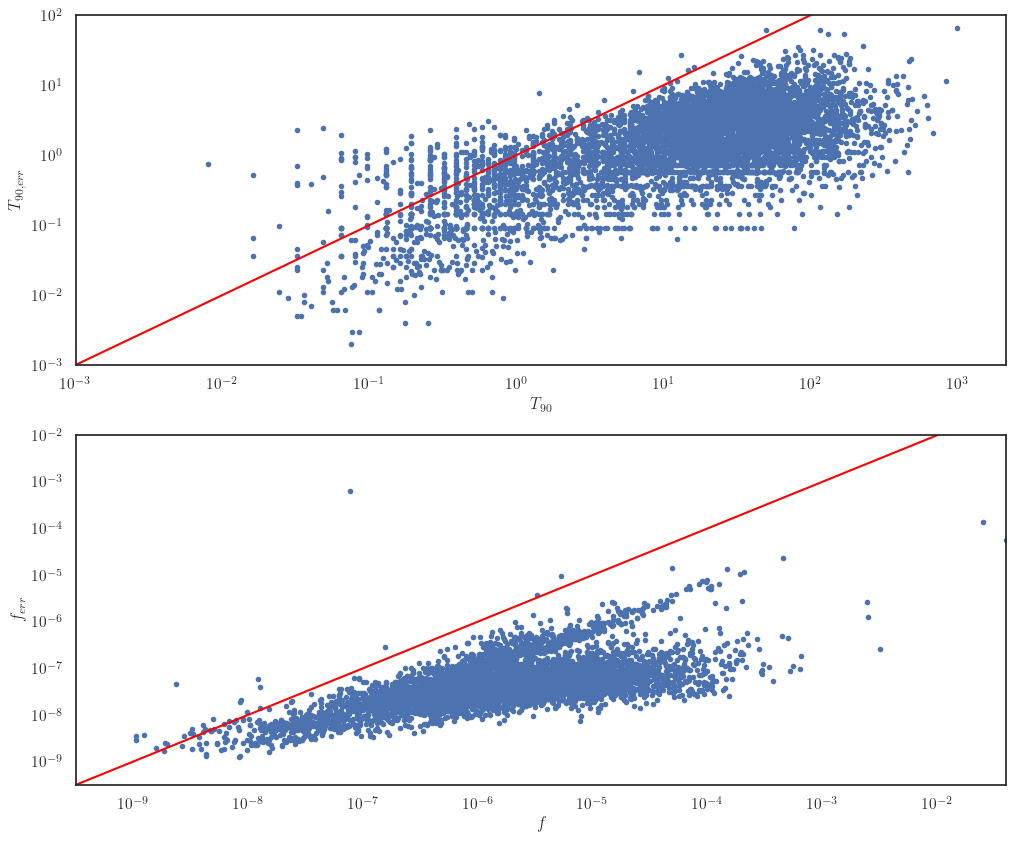

In [50]:
xgrid_t = np.logspace(-3, 2, 4) 
xgrid_f = np.logspace(-9.5, -2, 4)

fig, ax = plt.subplots(2, figsize=(12, 10))

ax[0].scatter(T90_corr, T90_corr_err, marker='.')
ax[0].plot(xgrid_t, xgrid_t, '-', c='red')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$T_{90}$')
ax[0].set_ylabel('$T_{90, err}$')


ax[1].scatter(fluence_corr, fluence_corr_err, marker='.')  # in both cases check if the error is of the order of the measurement
ax[1].plot(xgrid_f, xgrid_f, '-', c='red')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel('$f_{err}$'); 


By looking at the plots we can notice that in most cases the relative errors are very small, this means that we can avoid the errors in our analysis.

## PCA (from next lecture)

In [62]:
from sklearn.decomposition import PCA

In [56]:
flux_cor_err = fluence_s_err[mask]
T90_cor_err  = T90_s_err[mask]
T90_cor      = T90_s[mask]
flux_cor     = fluence_s[mask]
z_cor        = z_s[mask]

In [58]:
components = np.array([z_cor, T90_cor, flux_cor, T90_cor_err, flux_cor_err]).T

In [60]:
components.shape

(7355, 5)

In [63]:
# Compute the PCA
evals = []

for feature in np.arange(1,6, dtype=int):
    pca = PCA(n_components=feature, whiten=True)
    pca.fit(components)

evals.append(pca.explained_variance_ratio_)

In [64]:
evals

[array([8.01582315e-01, 1.83061843e-01, 1.53391557e-02, 1.66863535e-05,
        9.14626653e-13])]

In [71]:
n_features = np.arange(1, components.shape[1]+1, dtype=int)
n_features

array([1, 2, 3, 4, 5])

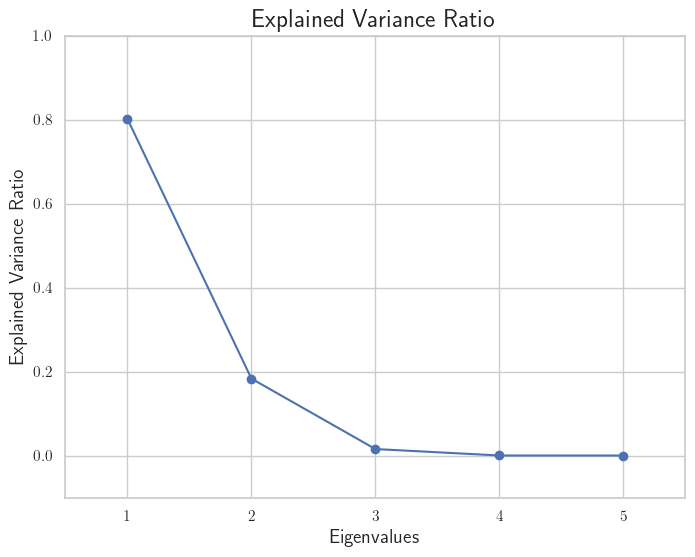

In [79]:
sns.set_style('whitegrid')

plt.scatter(n_features, evals[0])
plt.plot(n_features, evals[0])
plt.xlim(0.5, 5.5)
plt.ylim(-0.1, 1)
plt.xlabel('Eigenvalues', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.title('Explained Variance Ratio', fontsize=18);

The first component well explains the $80$% of the total variance. To be precise I should keep $3$ components, where the gradient becomes very close to zero.